In [41]:
import numpy as np
import pandas as pd
import os

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['lines.linewidth'] = 2
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['axes.titlesize'] = 20

%matplotlib inline

from sklearn.model_selection import train_test_split

import skimage.io
from skimage.transform import resize

In [3]:
### Here we load in all the relevant neural network packages ###
import tensorflow as tf

# from keras.applications import xception, vgg16, vgg19, mobilenet
# from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.models import Model
from keras import optimizers
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, Input, concatenate, Conv2DTranspose
from keras.layers.core import Dense, Dropout, Activation
# from keras.utils import np_utils, multi_gpu_model
# from keras.optimizers import SGD, Adam
# from keras.datasets import mnist
from keras import backend as K
# from keras import applications
from keras.preprocessing.image import ImageDataGenerator

In [9]:
def filter_directory_list(directorylisting):
    if '.DS_Store' in directorylisting:
        directorylisting.remove('.DS_Store')
    return directorylisting

In [67]:
def load_image(path):
    return skimage.io.imread(path)[:,:,:1]

def load_mask(path):
    return skimage.io.imread(path)

def custom_bigger(x):
    target_image_size = (128,128,1)
    return resize(x, (128,128,1), mode='constant', preserve_range=True)

### Load in the training/validation data

In [144]:

### Load in the whole list then eliminate those that are bad ###
traindir = '../../train/'
all_image_files = np.array(os.listdir(filter_directory_list(traindir + 'images/')))

### Find out which images are blanks, eliminate them from the training set list ###
image_sums = np.array([skimage.io.imread(traindir + 'images/' + x).sum() for x in all_image_files])
good_training_images = all_image_files[np.argwhere(image_sums > 1000).reshape(-1)]

### Load in the images ###
# images = np.array([load_image(traindir + 'images/' + x) for x in good_training_images])
images = np.array([custom_bigger(load_image(traindir + 'images/' + x)) for x in good_training_images])

### Load in the masks ###
# masks = np.array([load_mask(traindir + 'masks/' + x) for x in good_training_images])
masks = np.array([custom_bigger(load_mask(traindir + 'masks/' + x)) for x in good_training_images])

In [145]:
images = images / 255

Calculate mask coverage to do the stratified sampling, as inspired by https://www.kaggle.com/phoenigs/u-net-dropout-augmentation-stratification

In [146]:
### Calculate the mask coverage to do stratified sampling ###
# maskdf = pd.DataFrame([train_mask_files, list(masks)]).T
# maskdf.columns = ['id','mask']

### Normalize the masks to 0/1
masks = masks.astype(np.bool).astype(np.int8)

### Find the area of the grid ###
area = masks.shape[1] * masks.shape[2]

### Find the fractional covereage of each mask ###
coverage = masks.sum(axis=(1,2)) / area

### Cast into a category every 0.1 coverage. 0 coverage gets its own class too ###
coverage_category = np.ceil(coverage * 10)

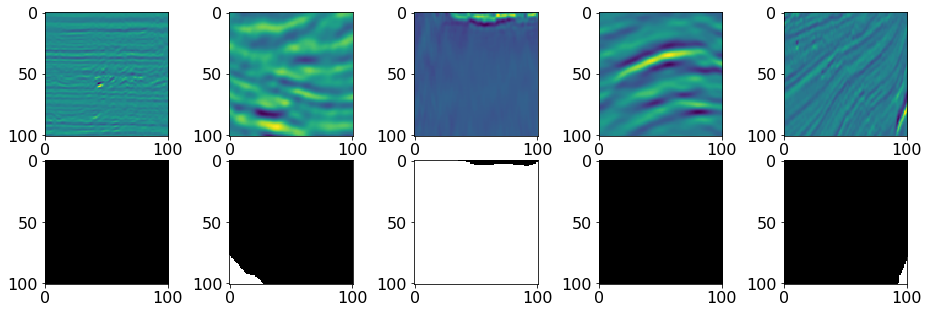

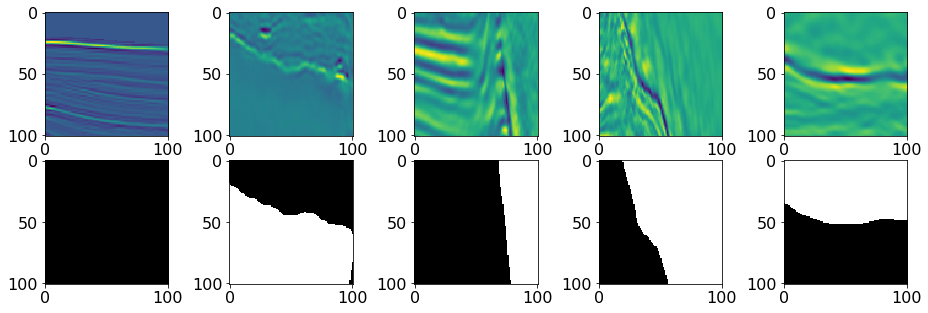

In [143]:
plt.figure(figsize=(16,5))
num_images = 5
for i in range(num_images):
    curr_image = images[i,:,:,0]
    curr_mask  = masks[i,:,:]
    
    plt.subplot(2,num_images,i+1); 
    plt.imshow(curr_image)#, cmap='gray')
    
    plt.subplot(2,num_images,num_images + i + 1); 
    plt.imshow(curr_mask, cmap='gray')
    
plt.figure(figsize=(16,5))
for i in range(num_images,2*num_images):
    curr_image = images[i,:,:,0]
    curr_mask  = masks[i,:,:]
    
    plt.subplot(2,num_images,i+1 - num_images); 
    plt.imshow(curr_image)#, cmap='gray')
    
    plt.subplot(2,num_images,num_images + i + 1 - num_images); 
    plt.imshow(curr_mask, cmap='gray')

Split into the training and validation sets

(array([  211615.,  1157831.,  4893880., 12930616., 17547087., 14513767.,
         8578454.,  3223417.,   865190.,   303423.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

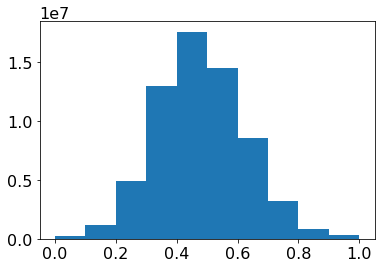

In [123]:
plt.hist(images.reshape(-1))

In [147]:
train_images, val_images, train_masks, val_masks = train_test_split(images, masks, stratify=coverage_category, \
                                                                    test_size=0.2, random_state=42)

### Implement the UNet model

In [149]:
filter_scaling = 4

input_layer = Input((128,128,1))

down_conv1 = Conv2D(1 * filter_scaling, (3,3), activation='relu', padding='same')(input_layer)
down_conv1 = Conv2D(1 * filter_scaling, (3,3), activation='relu', padding='same')(down_conv1)

down_maxp1 = MaxPooling2D((2,2), padding='same')(down_conv1)

down_conv2 = Conv2D(2 * filter_scaling, (3,3), activation='relu', padding='same')(down_maxp1)
down_conv2 = Conv2D(2 * filter_scaling, (3,3), activation='relu', padding='same')(down_conv2)

down_maxp2 = MaxPooling2D((2,2), padding='same')(down_conv2)

bottom_conv3 = Conv2D(4 * filter_scaling, (3,3), activation='relu', padding='same')(down_maxp2)
bottom_conv3 = Conv2D(4 * filter_scaling, (3,3), activation='relu', padding='same')(bottom_conv3)

up_tran2 = Conv2DTranspose(2 * filter_scaling, (3,3), strides=(2,2), padding='same')(bottom_conv3)
up_conc2 = concatenate([down_conv2, up_tran2])
up_conv2 = Conv2D(2 * filter_scaling, (3,3), activation='relu', padding='same')(up_conc2)
up_conv2 = Conv2D(2 * filter_scaling, (3,3), activation='relu', padding='same')(up_conv2)

up_tran1 = Conv2DTranspose(1 * filter_scaling, (3,3), strides=(2,2), padding='same')(up_conv2)
up_conc1 = concatenate([down_conv1, up_tran1])
up_conv1 = Conv2D(1 * filter_scaling, (3,3), activation='relu', padding='same')(up_conc1)
up_conv1 = Conv2D(1 * filter_scaling, (3,3), activation='relu', padding='same')(up_conv1)

output_layer = Conv2D(1, (1,1), activation='softmax', padding='same')(up_conv1)

In [150]:
model = Model(input_layer, output_layer)

In [151]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [120]:
batch_size = 32
history = model.fit(train_images, train_masks,
                    validation_data=[val_images, val_masks],
                    epochs=2,
                    batch_size=batch_size)

Train on 3136 samples, validate on 784 samples
Epoch 1/2
3136/3136 [==============================] - 71s 23ms/step - loss: 11.9752 - acc: 0.2489 - val_loss: 11.9596 - val_acc: 0.2498
Epoch 2/2
3136/3136 [==============================] - 72s 23ms/step - loss: 11.9752 - acc: 0.2489 - val_loss: 11.9596 - val_acc: 0.2498


In [152]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_185 (Conv2D)             (None, 128, 128, 4)  40          input_24[0][0]                   
__________________________________________________________________________________________________
conv2d_186 (Conv2D)             (None, 128, 128, 4)  148         conv2d_185[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_44 (MaxPooling2D) (None, 64, 64, 4)    0           conv2d_186[0][0]                 
__________________________________________________________________________________________________
conv2d_187

In [91]:
filter_scaling = 4
depth = 4

input_layer = Input((128,128,1))

conv_dict = {}
for i in range(1,depth):
    if i==1:
        x = Conv2D(i * filter_scaling, (3,3), activation='relu', padding='same')(input_layer)
    else:
        x = Conv2D(i * filter_scaling, (3,3), activation='relu', padding='same')(x)
        
    conv_dict[i] = Conv2D(i * filter_scaling, (3,3), activation='relu', padding='same')(x)
    
    x = MaxPooling2D((2,2), padding='same')(conv_dict[i])

### The bottom of the network ###
x = Conv2D(depth * filter_scaling, (3,3), activation='relu', padding='same')(x)
x = Conv2D(depth * filter_scaling, (3,3), activation='relu', padding='same')(x)

for i in range(depth-1,0,-1):
    
    x = Conv2DTranspose(i * filter_scaling, (3,3), strides=(2,2), padding='same')(x)
    x = concatenate([conv_dict[i], x])
    x = Conv2D(2 * filter_scaling, (3,3), activation='relu', padding='same')(x)
    x = Conv2D(2 * filter_scaling, (3,3), activation='relu', padding='same')(x)

output_layer = Conv2D(1, (1,1), activation='softmax', padding='same')(x)

In [92]:
model = Model(input_layer, output_layer)

In [93]:
model.layers

In [94]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [98]:
batch_size = 32
history = model.fit(train_images, train_masks,
                    validation_data=[val_images, val_masks],
                    epochs=2,
                    batch_size=batch_size)

Train on 3136 samples, validate on 784 samples
Epoch 1/2
3136/3136 [==============================] - 85s 27ms/step - loss: 11.9752 - acc: 0.2489 - val_loss: 11.9596 - val_acc: 0.2498
Epoch 2/2
3136/3136 [==============================] - 86s 27ms/step - loss: 11.9752 - acc: 0.2489 - val_loss: 11.9596 - val_acc: 0.2498


In [102]:
masks.shape

(3920, 128, 128, 1)

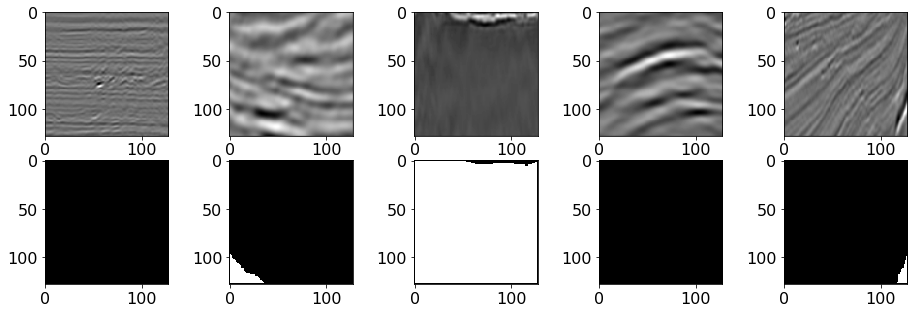

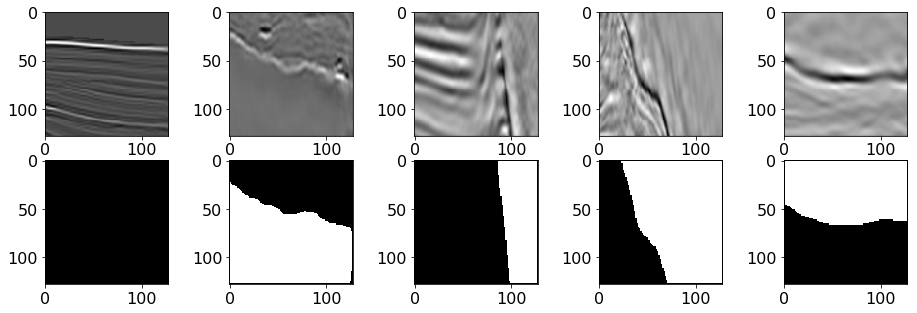

In [148]:
plt.figure(figsize=(16,5))
num_images = 5
for i in range(num_images):
    curr_image = images[i,:,:,0]
    curr_mask  = masks[i,:,:,0]
    
    plt.subplot(2,num_images,i+1); 
    plt.imshow(curr_image, cmap='gray')
    
    plt.subplot(2,num_images,num_images + i + 1); 
    plt.imshow(curr_mask, cmap='gray')
    
plt.figure(figsize=(16,5))
for i in range(num_images,2*num_images):
    curr_image = images[i,:,:,0]
    curr_mask  = masks[i,:,:,0]
    
    plt.subplot(2,num_images,i+1 - num_images); 
    plt.imshow(curr_image, cmap='gray')
    
    plt.subplot(2,num_images,num_images + i + 1 - num_images); 
    plt.imshow(curr_mask, cmap='gray')

In [105]:
from keras.preprocessing.image import load_img

In [129]:
tst = load_img('../../train/images/000e218f21.png')

In [130]:
np.array(tst).shape

(101, 101, 3)